# JAL-AM

In [252]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from model_lib import *
#from JAL_AM_lib import *

In [431]:
@njit
def update_AV(AV, s, Q, pi_other, state, k):
    for i in range(len(AV)): 
        AV[s,i]=Q[i,s]*pi_other[s,i]
    return AV


    
    

In [432]:
@njit
def update_agent_model(agent_model, state, action, counter,k):
    """
    args:
        state: the current state of player j
        action: action of player j
        counter: array holding count of every action played in each state
    returns:
        counter: the updated counter
        agent_model: the updated agent model
    """
    counter[state, action] += 1
    # måske skal man opdatere alle agent models af gangen og ikke kun 1
    for i in range(k):
        agent_model[state,i] = counter[state, i] / np.sum(counter[state,:])
    #print(agent_model)
    return counter, agent_model

In [433]:
@njit
def select_price(j, t, p_table, Q_table, price_grid, epsilon,pi_other,k, AV):
    """
    args:
        j: player 1
        t: current period
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table
        price_grid: price_grid
        epsilon: decay parameter of learning module
    returns:
        random price or maximized price
    """
    s_t_idx = np.where(price_grid == p_table[j, t-1])[0][0] # current state (opponent's price)
    #AV = calculate_AV(Q_table, pi_other,s_t_idx, k)
    # Exploration
    #epsilon=0.1
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(price_grid)
    else:
    # Exploitation
        maxedQ_idx=np.argmax(AV[s_t_idx,:])
        return price_grid[maxedQ_idx]

In [434]:
@njit
def Q_func(p_curr_idx, s_curr_idx, i, j, t, alpha, gamma, p_table, Q_table, price_grid, s_next,pi_other,T,AV) -> float: # p_table contains p and s (opponent price)
    """
    args:
        p_curr_idx: current price of player i
        s_curr_idx: current state of player i
        i: player 0
        j: player 1
        t: current period
        alpha: step-size parameter
        gamma: discount factor
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table for player i
        price_grid: price_grid
        s_next: next state for player i
    returns:
        updated value for Q_table 
    """
    prev_est = Q_table[p_curr_idx, s_curr_idx]
    s_next_index=np.where(price_grid == s_next)[0][0]
    
    # Beregn de forventede Q-værdier ved at bruge AV
    #AV = calculate_AV(Q_table, pi_other, s_next_index,7)
    
    # Vælg den handling for næste tilstand med den højeste AV-værdi
    Max_AV_idx = np.argmax(AV[s_next_index,:])
    Max_AV=price_grid[Max_AV_idx]
    
    # Beregn den forventede fremtidige værdi ved at bruge den valgte AV-værdi
    
    reward = profit(p_table[i, t], p_table[j, t-2]) + gamma * profit(p_table[i, t], s_next) + gamma**2 * Max_AV
    return (1 - alpha) * prev_est + alpha * reward

In [435]:
@njit
def JAL_AM(alpha, gamma, T, price_grid):
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    k = len(price_grid)
    q1 = np.zeros((k, k)) 
    q2 = np.zeros((k, k)) 
    # Initializing policies
    Agent_model_1 = np.ones((k, k)) / k
    Agent_model_2 = np.ones((k, k)) / k
    AV_1= np.ones((k,k))
    AV_2= np.ones((k,k))

    # Initializing N, a counter
    N1 = np.zeros((k, k))
    N2 = np.zeros((k, k))
    
    # Initializing profits
    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    # Setting random price and state for t = 0
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    
    t += 1
    # Setting random price and state for t = 1
    p_table[i,t] = np.random.choice(price_grid)
    p_table[j,t] = np.random.choice(price_grid)
    t += 1
    for t in range(t,T):
        #print("hey")
        p_table[i,t] = p_table[i,t-1]
        p_idx = np.where(price_grid == p_table[i,t])[0][0]
        s_next = p_table[j,t-1]
        current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]
        # opdatering af q skal vel flyttes længere ned?
        update_AV(AV_1,current_state_idx,q1,Agent_model_2,current_state_idx,k)
        q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, gamma, p_table, q1, price_grid, s_next, Agent_model_2,T, AV_1)

        p_table[i,t] = select_price( j, t, p_table, q1, price_grid, epsilon[t], Agent_model_2,k,AV_1)
        p_table[j, t] = p_table[j, t-1]
        opponent_price_idx = np.where(price_grid==p_table[j,t])[0][0]
        N2, Agent_model_2= update_agent_model(Agent_model_2,current_state_idx, opponent_price_idx, N2,k)
        # Store profits for both firms
        profits[i, t] = profit(p_table[i,t], p_table[j,t])
        profits[j, t] = profit(p_table[j,t], p_table[i,t])

        
        
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        #print(Agent_model_1)
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        Agent_model_1, Agent_model_2 = Agent_model_2, Agent_model_1
        N1,N2=N2,N1
        AV_1,AV_2=AV_2,AV_1
    return p_table, avg_profs1, avg_profs2


In [448]:
k = np.linspace(0,1,7)
a, b, c = JAL_AM(0.3, 0.95, 500000, k)

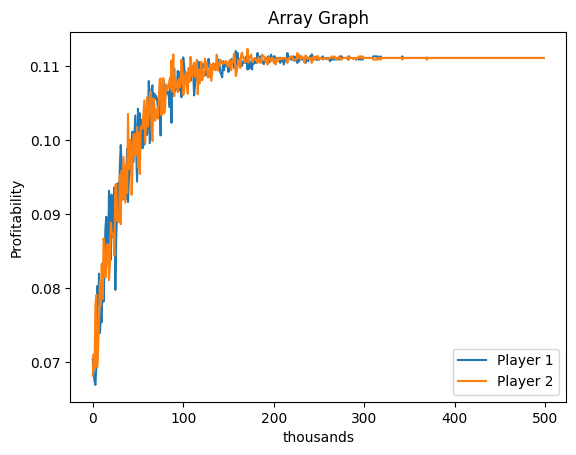

In [449]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [450]:
print(a[0, 490000:490010])

[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333]


In [451]:
def run_sim(n, k):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs=int(500000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    t=n
    # simulating n runs of Klein_simulation
    for n in range(0, n):
        p_table, avg_profs1, avg_profs2 = JAL_AM(0.3, 0.95, 500000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)

    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities, t

In [452]:
avg_prof,n= run_sim(100, np.linspace(0,1,7))

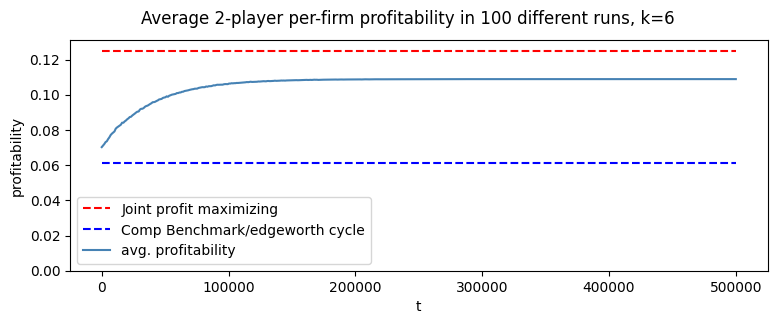

In [453]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(n, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [454]:
avg_prof[498]

0.10886644219977719

0.09415772306397278

In [401]:
counter=np.ones((4,4))
counter[3, 3] / np.sum(counter[3,:])


0.25